Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## Mounting the Google Drive for data
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Counting the number of images in the train and test folders before doing any processing
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
#Setting the batch_size to 32 and image dimensions to 180,180 as specified in the project pipeline
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Setting the train dataset along with seed and necessary arguments
train_ds = tf.keras.utils.image_dataset_from_directory( 
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Setting the validation dataset for checking model performance along with seed and necessary arguments
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list. 
# as per the class_names attribute. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

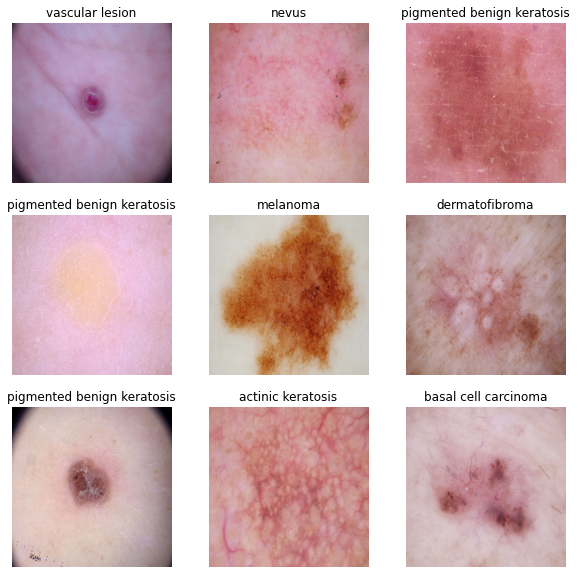

In [9]:
import matplotlib.pyplot as plt

### Visualizing each of the cancer classes from the training data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Creating the network architecture with the specification of the necessary layers and related configuration
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Setting the optimiser and the loss function for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary and architecture of all network layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
#Training the model with 20 epochs and checking the model performance on validation dataset simultaneously for each epoch

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 237s 920ms/step - loss: 2.0507 - accuracy: 0.2360 - val_loss: 1.8276 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7795 - accuracy: 0.3616 - val_loss: 1.6466 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5285 - accuracy: 0.4766 - val_loss: 1.4547 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3705 - accuracy: 0.5268 - val_loss: 1.3668 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2877 - accuracy: 0.5530 - val_loss: 1.3752 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1764 - accuracy: 0.5787 - val_loss: 1.3394 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1561 - accuracy: 0.5876 - val_loss: 1.4097 - val_accuracy: 0.5302
Epoch 8/20

### Visualizing training results

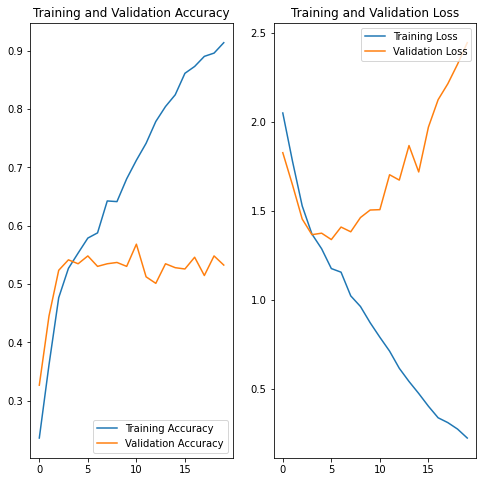

In [15]:
#Visualizing and comparing the model performance on training and validation dataset - comparing the accuracy as well as the loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
We can see that after training the model for 20 epochs - 

*   The validation accuracy is significantly less than the training accuracy and
*   The validation loss is significantly higher than the training loss

This shows that the model is overfitting on the training dataset and we need an appropriate data augmentation strategy to resolve this



In [16]:
# Based on the overfitting/underfitting observed in the first model iteration, we need to choose a suitable data augmentation strategy

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

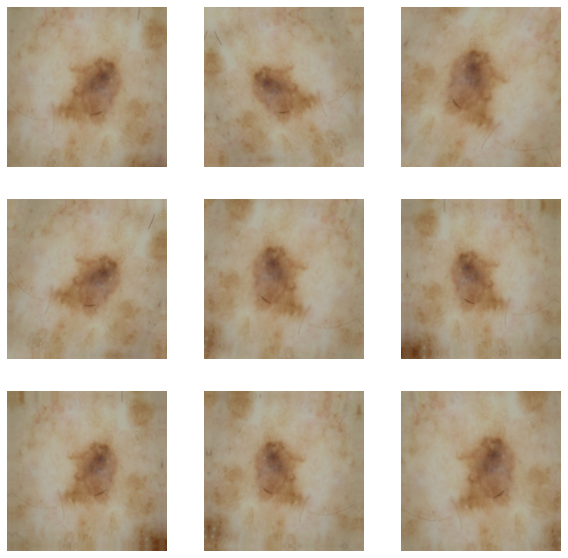

In [17]:
# Visualizing how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## Dropout layer added to fix the issue of overfitting

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


### Compiling the model

In [19]:
## Specifying the optimiser and the loss function for the 2nd model iteration

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Training the model for 20 epochs


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 2.0344 - accuracy: 0.2416 - val_loss: 1.8265 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 1s 27ms/step - loss: 1.7890 - accuracy: 0.3521 - val_loss: 1.7153 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.5761 - accuracy: 0.4330 - val_loss: 1.5276 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4424 - accuracy: 0.5000 - val_loss: 1.4069 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3798 - accuracy: 0.5212 - val_loss: 1.4083 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3747 - accuracy: 0.5061 - val_loss: 1.4635 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3270 - accuracy: 0.5312 - val_loss: 1.3708 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

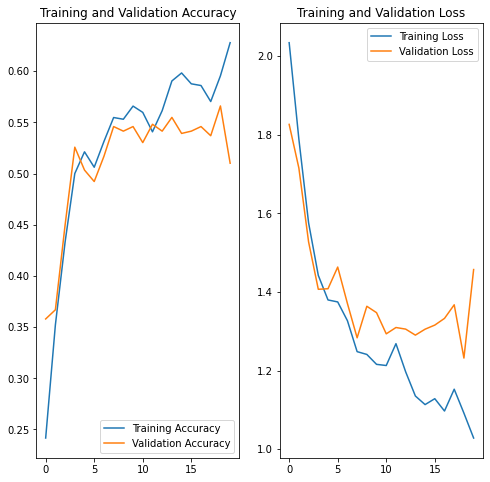

In [21]:
#Visualizing and comparing the model performance on training and validation dataset - comparing the accuracy as well as the loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Finding from Second Model - 

*   There is drop in training accuracy, but after data augmentation, there is hardly any overfitting now as the training and validation accuracy values are very close



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
# ## Your code goes here.
# path_list=[]
# lesion_list=[]
# for i in class_names:
      
#     for j in data_dir_train.glob(i+'/*.jpg'):
#         path_list.append(str(j))
#         lesion_list.append(i)
# dataframe_dict_original = dict(zip(path_list, lesion_list))
# original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# original_df

In [23]:
from pathlib import Path

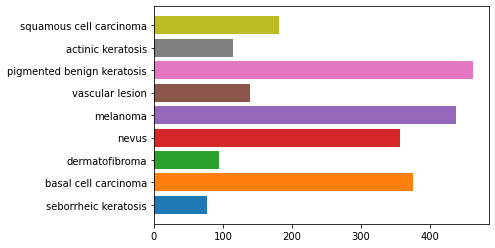

In [24]:
#Getting the class wise count of images to check for class imbalance in the training dataset

import os
path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # getting the sub-directories for all the classes of cancer
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) 
    if len(contents) >= mn: 
        plt.barh(folder,len(contents))

# We can clearly see there is class imbalance and we will need to image augmentation to bring down the imbalance

In [25]:
# dataframe_dict_original = dict(zip(path_list, lesion_list))
# original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# original_df

In [26]:
# count=[]
# for i in class_names:
#     count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
# plt.figure(figsize=(25,10))
# plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? - seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? - pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
#Installing the Augmentor library for image augmentation to reduce the class imbalance

!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
# path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [29]:
# Specifying the path for the training dataset before performing the image augmentation

path_to_training_dataset='/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [30]:
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train",save_format='jpg')
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [31]:
# Importing the Augmentor class for image augmentation

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F083E1B8550>: 100%|██████████| 500/500 [00:19<00:00, 25.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08D1F79350>: 100%|██████████| 500/500 [00:20<00:00, 24.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F085626F490>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F083E186450>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F083E1802D0>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08D1FC8950>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F085650C850>: 100%|██████████| 500/500 [00:43<00:00, 11.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08D1F79390>: 100%|██████████| 500/500 [00:20<00:00, 24.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08D20E05D0>: 100%|██████████| 500/500 [00:18<00:00, 26.83 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
# image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
# print(image_count_train)

In [33]:
# data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
# image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
# print(image_count_train1)

In [34]:
#Creating the object for the augmented training dataset directory
data_dir_train = pathlib.Path(path_to_training_dataset)

In [35]:
print(data_dir_train)

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [36]:
#Checking the number of images generated after data augmentation

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [37]:
# for i in class_names:
      
#     for j in data_dir_train1.glob(i+'/*.jpg'):
#         path_list.append(str(j))
#         lesion_list.append(i)
# dataframe_dict_original = dict(zip(path_list, lesion_list))
# new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# new_df

### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
import glob

In [39]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011013.jpg_dcc2eb52-b1ab-4087-900e-a1235af63c6b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_ddf67ffe-4e5e-4ecc-a965-634ec0181051.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_32efbd97-91dc-4b09-922f-7284d4756c05.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_f147e432-66d5-439e-9f5a-c2627335bd07.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [43]:
# Getting the distribution of images after augmentation

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
#Specifying the batch_size as 32 and image dimensions as per project pipeline
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
#Creating training dataset for the 3rd iteration of the model

data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
#Creating validation dataset for the 3rd iteration of the model

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## Including the normalization layer for the architecture of the 3rd model

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.056209315 1.0


In [48]:
# ## your code goes here
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# num_classes = 9
# model = Sequential([ 
#                     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
# ])
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (180, 180, 32)))
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


# model.add(Flatten())
# model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
#Specifying the optimiser and the loss function for the model training

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
# Training the model for 30 epochs

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 30s 170ms/step - loss: 0.4070 - accuracy: 0.8487 - val_loss: 0.6963 - val_accuracy: 0.8114
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 0.4517 - accuracy: 0.8309 - val_loss: 0.8100 - val_accuracy: 0.8040
Epoch 3/30
169/169 [==============================] - 30s 171ms/step - loss: 0.3975 - accuracy: 0.8494 - val_loss: 0.6231 - val_accuracy: 0.8218
Epoch 4/30
169/169 [==============================] - 30s 171ms/step - loss: 0.4140 - accuracy: 0.8429 - val_loss: 0.7073 - val_accuracy: 0.7958
Epoch 5/30
169/169 [==============================] - 30s 172ms/step - loss: 0.3694 - accuracy: 0.8574 - val_loss: 0.6992 - val_accuracy: 0.8270
Epoch 6/30
169/169 [==============================] - 31s 178ms/step - loss: 0.4547 - accuracy: 0.8310 - val_loss: 0.6614 - val_accuracy: 0.8211
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 0.3765 - accuracy: 0.8618 - val_loss: 0.6862 - val_ac

#### **Todo:**  Visualize the model results

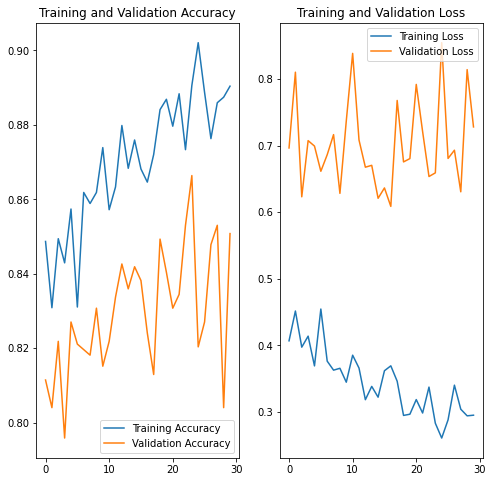

In [53]:
#Visualizing and comparing the model performance on training and validation dataset - comparing the accuracy as well as the loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



*   The above graph indicates that the overfitting/underfitting issue has been resolved as the difference between training and validation accuracy values is insignificant
*   Yes, class rebalancing helped to increase the accuracy significantly

